# Brain Food:
## Recipe Recommender System

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import spacy
import gensim
import time
import re
import string
import scipy
import collections

from nltk.corpus import stopwords
from stop_words import get_stop_words
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from spacy.lang.en.stop_words import STOP_WORDS
from gensim.summarization import keywords
from gensim.models import word2vec
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, LogisticRegression

%matplotlib inline

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', -1)

import warnings
warnings.filterwarnings('ignore')

c:\users\corey\appdata\local\programs\python\python37\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Load Data

In [2]:
# Recipe directory path
path = os.path.join(os.getcwd(),'recipes')
recipes = os.listdir(path)

# Load in data
list_ = []
for recipe in recipes:
    df = pd.read_json(os.path.join(path,recipe), compression='xz', lines=True, encoding='Latin-1')
    list_.append(df)
    
# Get Column names and shape of each dataset
recipes_ = [x.split('.')[0].replace('-',' ').upper() for x in recipes]
data_cols = {}
for df,name in enumerate(recipes_):
    data_cols[name]=[list_[df].columns.tolist(),list_[df].shape]

# check columns from each dataset for merging
col_df = pd.DataFrame(data_cols)
print(col_df)

                                                                                                                                                                              ALLRECIPES RECIPES  \
0  [author, cook_time_minutes, description, error, footnotes, ingredients, instructions, photo_url, prep_time_minutes, rating_stars, review_count, time_scraped, title, total_time_minutes, url]   
1  (225602, 15)                                                                                                                                                                                    

                                                                                                                                                                                                               BBCCOUK RECIPES  \
0  [chef, chef_id, cooking_time_minutes, description, error, ingredients, instructions, instructions_detailed, photo_url, preparation_time_minutes, program, program_id, serves, time_scr

# Prep Data

In [3]:
################################ Allrecipes Recipes ################################
allrecipes = list_[0]

# Drop error, author, time_scraped, photo_url
# Error Column is always False, Author is user_name for website, time_scraped and photo_url aren't important

allrecipes = allrecipes.drop(['author', 'error', 'time_scraped', 'photo_url'], 1)

# change name of rating-stars to rating, and drop minutes from time variables
allrecipes.rename({'rating_stars':'rating', 
                   'cook_time_minutes':'cook_time',
                   'prep_time_minutes':'prep_time',
                   'total_time_minutes':'total_time'}, axis=1, inplace=True)

# combine the footnote column with the description column
allrecipes.footnotes = allrecipes.footnotes.apply(str)
allrecipes.description = allrecipes.description.str.cat(allrecipes.footnotes, sep=' ')
allrecipes.description = allrecipes.description.str.replace('[','').str.replace(']','')

# Drop footnote
allrecipes = allrecipes.drop('footnotes',1)


# Drop duplicates
allrecipes.ingredients = allrecipes.ingredients.apply(', '.join)
allrecipes = allrecipes.drop_duplicates(subset='ingredients',keep='first')



################################ BBC CO UK Recipes ################################
bbcrecipes = list_[1]

# Add program to descriptions
bbcrecipes.program = bbcrecipes.program.apply(str)
bbcrecipes.description = bbcrecipes.description.str.cat(bbcrecipes.program, sep=' ')

# Drop error, chef, chef_id, instructions_detailed, photo_url, program, program_id, serves, time_scraped
bbcrecipes = bbcrecipes.drop(['error', 'chef', 'chef_id', 
                              'instructions_detailed', 'photo_url', 
                              'program', 'program_id', 'serves', 'time_scraped'], 1)

bbcrecipes.rename({'cooking_time_minutes':'cook_time',
                   'preparation_time_minutes':'prep_time',
                   'total_time_minutes':'total_time'}, axis=1, inplace=True)



################################ COOKSTR Recipes ################################
cookstrecipes = list_[2]

# Append the cookbook, publisher cooking_method, cost, course, chef, contributor, dietary_considerations, 
# difficulty, meal, occasion, taste/texture, and type of dish to the description

# Change description to og_description
cookstrecipes.rename(columns={'description':'description_og'}, inplace=True)
cols_to_append = ['chef', 'contributors', 'cookbook', 'cookbook_publisher', 
                  'cooking_method', 'cost', 'course', 'dietary_considerations',
                  'difficulty', 'meal', 'occasion', 'taste_and_texture', 'type_of_dish']
cookstrecipes['description'] = cookstrecipes['description_og'].str.cat(cookstrecipes[cols_to_append].astype(str), sep=' ', na_rep=' ')

# Drop cols to append, comment_count, copyright, date_modified, error, 
# ingredients_detailed, kid_friendly, make_ahead, makes, photo stuff, and time scraped
drop_cols = cols_to_append +['description_og','rating_count', 'comment_count', 'copyright',
                                  'date_modified','error','ingredients_detailed',
                                  'kid_friendly','make_ahead','makes',
                                  'photo_credit_name','photo_credit_site','photo_url','time_scraped']
cookstrecipes = cookstrecipes.drop(drop_cols, 1)

# Fill missing ratings with 0
cookstrecipes.rating_value.fillna(0,inplace=True)

# Rename rating
cookstrecipes.rename({'rating_value':'rating'}, axis=1, inplace=True)



################################ epicurious check ################################
epicuriousrecipes = list_[3]

# Description = dek+hed+prepSteps (Instructions)
epicuriousrecipes['description'] = epicuriousrecipes.dek.str.cat([epicuriousrecipes.hed.map(str)], sep=' ')

# Rename columns
epicuriousrecipes.rename({'prepSteps':'instructions', 
                          'aggregateRating':'rating', 
                          'reviewsCount':'review_count'}, axis=1, inplace=True)

# Change rating scale to 0-5
epicuriousrecipes.rating = epicuriousrecipes.rating*(5/4)

# Drop 100 missing ingredient recipes and other columns
epicuriousrecipes = epicuriousrecipes.dropna(0)
drop_cols = ['author','dateCrawled', 'id', 'dek', 'hed', 'photoData', 'pubDate', 'type', 'willMakeAgainPct', 'tag']
epicuriousrecipes = epicuriousrecipes.drop(drop_cols,1)



################################ Make full dataframe ################################
dfs = [allrecipes, bbcrecipes, cookstrecipes, epicuriousrecipes]
df_all = pd.concat(dfs,0,sort=True,ignore_index=True)
print("Done!\nFull recipe dataset is ready!")
print("Final shape: {:,} rows with {} columns".format(df_all.shape[0], df_all.shape[1]))

# Check out missings
nulls = df_all.isnull().sum(axis=0)
counts = df_all.count(axis=0)
perc = (round((nulls/counts)*100)).astype(int)
print("\nMissings by column")
print(perc.apply(lambda x: str(x)+str('% missing')))

Done!
Full recipe dataset is ready!
Final shape: 144,247 rows with 10 columns

Missings by column
cook_time       42% missing
description     0% missing 
ingredients     0% missing 
instructions    0% missing 
prep_time       42% missing
rating          8% missing 
review_count    15% missing
title           32% missing
total_time      32% missing
url             0% missing 
dtype: object


# Clean Text

In [4]:
# Drop missings
recipe_df = df_all.dropna(1)

# Add title and rating back
recipe_df['title'] = df_all.title
recipe_df['rating'] = df_all.rating

# Pad columns to avoid issues when concatenating columns
for col in ['description', 'instructions']:
    recipe_df.loc[:,col] = recipe_df.loc[:,col].apply(lambda x: ' '+str(x))

# create "corpus" for each recipe
recipe_df.loc[:,'corpus'] = recipe_df['ingredients'].astype(str)+\
                            recipe_df['instructions'].astype(str)+\
                            recipe_df['description'].astype(str)

# Take a peak at the text
print(recipe_df.corpus[0])

1/2 cup unsalted butter, chilled and cubed, 1 cup chopped onion, 1 3/4 cups cornmeal, 1 1/4 cups all-purpose flour, 1/4 cup white sugar, 1 tablespoon baking powder, 1 1/2 teaspoons salt, 1/2 teaspoon baking soda, 1 1/2 cups buttermilk, 3 eggs, 1 1/2 cups shredded pepperjack cheese, 1 1/3 cups frozen corn kernels, thawed and drained, 2 ounces roasted marinated red bell peppers, drained and chopped, 1/2 cup chopped fresh basil ['Preheat oven to 400 degrees F (205 degrees C). Butter a 9x9x2 inch baking pan.', 'Melt 1 tablespoon butter in medium nonstick skillet over medium-low heat. Add onion and saute until tender, about 10 minutes. Cool.', 'Mix cornmeal with the flour, baking powder, sugar, salt, and baking soda in large bowl. Add 7 tablespoons butter and rub with fingertips until mixture resembles coarse meal.', 'Whisk buttermilk and eggs in medium bowl to blend. Add buttermilk mixture to dry ingredients and stir until blended. Mix in cheese, corn, red peppers, basil, and onion. Transf

In [5]:
# Wikipedia stopwords
wiki_stop = ['a','able','about','across','after','all','almost','also','am','among','an','and','any','are','as',
                     'at','be','because','been','but','by','can','cannot','could','dear','did','do',
                     'does','either','else','ever','every','for','from','get','got','had','has','have','he',
                     'her','hers','him','his','how','however','i','if','in','into','is','it','its','just','least',
                     'let','like','likely','may','me','might','most','must','my','neither','no','nor','not','of','off',
                     'often','on','only','or','other','our','own','rather','said','say','says','she','should','since',
                     'so','some','than','that','the','their','them','then','there','these','they','this','tis','to',
                     'too','twas','us','wants','was','we','were','what','when','where','which','while','who','whom','why',
                     'will','with','would','yet','you','your']
# NLTK Stop words
nltk_stop = list(stopwords.words("English"))

# Stop_words stop words
stop_words_py = get_stop_words('english')

# sklearn stop words
sk_stop = list(ENGLISH_STOP_WORDS)

# spaCy stop words
spacy_stop = list(STOP_WORDS)

all_stopwords = set(wiki_stop+nltk_stop+stop_words_py+sk_stop+spacy_stop)


############################## text cleaner ##############################
def manual_text_cleaner(txt):
    
   # Remove all digits
    txt = re.sub(r'\d',' ',txt)
    
    # Remove punctuation.
    puncs = str.maketrans("","", string.punctuation)
    txt = txt.translate(puncs)
    
    # Remove stopwords
    txt = ' '.join([word for word in txt.split() if word not in (all_stopwords)])
    
    # make lowercase
    txt = txt.lower()
    
    # Get rid of extra whitespace.
    txt = ' '.join(txt.split())
    
    return txt
##########################################################################################

t0=time.time()
recipe_df.loc[:,'cleaned_text_1'] = recipe_df.corpus.apply(manual_text_cleaner)
print("Time to manually clean text: {:0.5f}s".format(time.time()-t0))

# Check our manual cleaning
print('\nClean Check #1:')
print(recipe_df.cleaned_text_1[0])

Time to manually clean text: 20.05804s

Clean Check #1:
cup unsalted butter chilled cubed cup chopped onion cups cornmeal cups allpurpose flour cup white sugar tablespoon baking powder teaspoons salt teaspoon baking soda cups buttermilk eggs cups shredded pepperjack cheese cups frozen corn kernels thawed drained ounces roasted marinated red bell peppers drained chopped cup chopped fresh basil preheat oven degrees f degrees c butter x x inch baking pan melt tablespoon butter medium nonstick skillet mediumlow heat add onion saute tender minutes cool mix cornmeal flour baking powder sugar salt baking soda large bowl add tablespoons butter rub fingertips mixture resembles coarse meal whisk buttermilk eggs medium bowl blend add buttermilk mixture dry ingredients stir blended mix cheese corn red peppers basil onion transfer prepared pan bake cornbread golden tester inserted comes clean minutes cool minutes pan cut cornbread squares i started adding favorite things basic cornbread i came grea

## Remove the most common non-food words
We need to find the most and least frequenct words in the data to remove them since they offer little significance in the model.  To find the most/least common words overall we will need to combine all of the data into a list then perform a frequency count with counter.

In [8]:
t0=time.time()

# Make a giant string of all text
soup = recipe_df.cleaned_text_1.tolist()

# Tokenize with nltk to count words
word_soup_tokens = []
for x in range(len(soup)):
    word_soup_tokens.append(word_tokenize(soup[x]))
    
# Flatten list
word_soup = [word for sublist in word_soup_tokens for word in sublist]
print("Time to make soup: {:0.5f}s".format(time.time()-t0))

# Count most frequent words in word soup
counter = collections.Counter(word_soup)

# Get top word count
word_count = pd.Series(counter).sort_values(ascending=False)

# Cut off top 1% of words
print('\nTop words cut-off = {} words'.format(np.around(np.quantile(word_count, .99), decimals=-2)))
word_count_top = word_count[word_count>3000]

# Write out drop-list for manual tagging
word_count_top.to_csv('C:\\Users\\Corey\\Desktop\\word_count_top.csv')
drop_list = pd.read_csv('drop_list.csv', names=['food','drop'])
drop_list = drop_list[drop_list['drop']==1]['food'].tolist()

# remove most frequent non food words 
def remove_most_freq(text):
    return ' '.join([word for word in text.split() if word not in drop_list])

t0=time.time()
recipe_df.loc[:,'cleaned_text_2'] = recipe_df.loc[:,'cleaned_text_1'].apply(remove_most_freq)
print('Time to remove most frequent non-food words: {:0.5f}s'.format(time.time()-t0))
print('\nClean Check #2:')
print(recipe_df.cleaned_text_2[0])

Time to make soup: 98.76101s

Top words cut-off = 3000.0 words
Time to remove most frequent non-food words: 93.11958s

Clean Check #2:
butter onion cornmeal flour sugar powder salt soda buttermilk eggs pepperjack cheese frozen corn kernels marinated bell peppers fresh basil butter butter onion tender cornmeal flour powder sugar salt soda large butter fingertips resembles buttermilk eggs buttermilk cheese corn peppers basil onion cornbread golden tester cornbread started favorite things basic cornbread came


# Parse Text, Lemmatize, and Build TFIDF Vectorizer for Finding Keywords

In [9]:
# Parse the dataset and tokenize - disable everything but the tokenizer
t0=time.time()
nlp = spacy.load('en', disable=['parser', 'tagger', 'ner'])

# Parse recipes
doc = recipe_df.cleaned_text_2.apply(nlp)
print("Time to parse text through spaCy: {:0.5f}s".format(time.time()-t0))
print("\nSpaCy tokens check:")
print(doc[0])

# Lemmatize
def get_lemmas(text):
    allwords = [token.lemma_ for token in text
                if token.is_alpha
                and not token.is_punct 
                and not token.is_stop 
                and not token.is_digit 
                and not token.like_num]
    return ' '.join(allwords)

t0=time.time()
doc_lemma = doc.apply(get_lemmas)
print("\nTime to get lemmas: {:0.5f}s".format(time.time()-t0))
print('\nSpaCy lemmas check:')
print(doc_lemma[0])

# Build TFIDF vectorizer
t0=time.time()
tfidf_vectorizer = TfidfVectorizer(strip_accents='unicode',
                                   min_df=2,
                                   stop_words='english',
                                   use_idf=True,
                                   norm='l2')#,
                                   #ngram_range=(1,2))
                                  
# Tfidf Matrix
X = tfidf_vectorizer.fit_transform(doc_lemma)
print("\nTime to create tfidf recipe matrix: {:0.5f}s".format(time.time()-t0))
print("TFIDF matrix shape: {} x {}".format(X.shape[0],X.shape[1]))

# Create tfidf vocab
vocab = tfidf_vectorizer.vocabulary_

Time to parse text through spaCy: 293.80170s

SpaCy tokens check:
butter onion cornmeal flour sugar powder salt soda buttermilk eggs pepperjack cheese frozen corn kernels marinated bell peppers fresh basil butter butter onion tender cornmeal flour powder sugar salt soda large butter fingertips resembles buttermilk eggs buttermilk cheese corn peppers basil onion cornbread golden tester cornbread started favorite things basic cornbread came

Time to get lemmas: 11.60703s

SpaCy lemmas check:
butter onion cornmeal flour sugar powder salt soda buttermilk egg pepperjack cheese freeze corn kernel marinate bell pepper fresh basil butter butter onion tender cornmeal flour powder sugar salt soda large butter fingertip resemble buttermilk egg buttermilk cheese corn pepper basil onion cornbread golden tester cornbread start favorite thing basic cornbread come

Time to create tfidf recipe matrix: 9.29269s
TFIDF matrix shape: 144247x32801


# Get Keywords by TFIDF score

In [10]:
def get_keywords2(csr_matrix):
    
    # Reverse order of vocabulary matrix
    index_word={i[1]:i[0] for i in vocab.items()}
    full_match = []
    for row in csr_matrix:
        # Append the word:tfidf value as a dictionary for each recipe (row)
        full_match.append(sorted([(index_word[word_col],tfidf_val) for (word_col,tfidf_val) in zip(row.indices,row.data)],
                                 key=lambda x: -x[1])[:10])
    return full_match

# Get keywords
tfidf_keywords = get_keywords2(X)

# Add keywords to recipe_df
def extract_keywords(li):
    return [word[0] for word in li]
def extract_vectors(li):
    return np.asarray([word[1] for word in li])

recipe_df['tfidf_keywords_scores'] = tfidf_keywords
recipe_df['tfidf_keywords'] = recipe_df['tfidf_keywords_scores'].apply(extract_keywords)
recipe_df['keyword_vectors'] = recipe_df['tfidf_keywords_scores'].apply(extract_vectors)

# Add top 3 keywords to NaN titles

In [11]:
# Add the top 3 keywords for NaN titles
missing_title_df = recipe_df[recipe_df['title'].isnull()]
indices = recipe_df[recipe_df['title'].isnull()].index

# Get top 3 keywords
new_titles = []
for row in missing_title_df.tfidf_keywords:
    new_titles.append('Top 3 Keywords: '+str(', '.join(row[:3])))

# Zip indices to new titles
new_title_dict = dict(zip(indices,new_titles))

# Fill NaN with new titles
recipe_df.title = recipe_df.title.fillna(new_title_dict)

# Function to return recipes given ingredients

In [12]:
def brain_food_1(input_list):
    
    # Parse into spacy and get lemmas
    tokens = nlp(input_list)
    lemmas = get_lemmas(tokens)
    
    # Input vector needs to match matrix shape
    input_vec = np.zeros(X.shape[1])
    
    # One hot encode input vector
    lemmas = lemmas.split()
    for word in lemmas:
        input_vec[vocab[word]] += 1
 
    # Multiply tfidf matrix by input vector and sum
    tfidf_sparse = scipy.sparse.csc_matrix(X)
    similarity = tfidf_sparse * input_vec
    
    # add to recipe_df
    recipe_df_alias = recipe_df.copy()
    recipe_df_alias['similarity'] = similarity
    recipe_df_alias = recipe_df_alias.sort_values(by='similarity', ascending=False)
    
    return recipe_df_alias[['title', 'cleaned_text_2', 'tfidf_keywords', 'url']].head(10)


# Run Function
#brain_food_1('potatoes cheese bacon eggs')

To improve the model above, we can add words that are similar to our input words to the input list to increase the diversity of recipes returned.  To do this we will build a word2vec model and use the vocabulary and word vectors to determine other similar words to our input words.

# Word2Vec

In [13]:
#Build list of lists for word2vec from cleaned and lemmatized corpus
lemma_list = [x.split() for x in doc_lemma]

# Instantiate word2vec model
t0=time.time()
print('Builing vocabulary...')
w2v = word2vec.Word2Vec(lemma_list,        # build vocabulary on entire corpus - must be list of lists
                        workers=8,         # Number of threads in parallel
                        min_count=10,      # Minimum word count threshold.
                        window=12,         # Number of words around target word to consider.
                        sg=0,              # Use CBOW because our corpus is small.
                        sample=1e-5,       # Penalize frequent words.
                        size=200,          # Word vector length.
                        hs=1,              # Use hierarchical softmax.
                        iter=10)           # Epoch=10
print('Done!')
print("Time to build word vectors: {:.5f}s".format(time.time()-t0))

Builing vocabulary...
Done!
Time to build word vectors: 34.20698s


In [14]:
# Test Word2Vec
test_list = ['cornbread', 'onion', 'corn', 'cheese', 'buttermilk', 'pepper']
for test in test_list:
    print(test)
    print(w2v.wv.most_similar(test,topn=5))
    print('-----'*20)

cornbread
[('creamstyle', 0.4833410978317261), ('cornmeal', 0.478206992149353), ('breadmuffin', 0.42467358708381653), ('stuff', 0.4045991897583008), ('gospel', 0.39234232902526855)]
----------------------------------------------------------------------------------------------------
onion
[('pepper', 0.7257182598114014), ('garlic', 0.6391535997390747), ('bell', 0.6260587573051453), ('clove', 0.5635421276092529), ('tender', 0.560741662979126)]
----------------------------------------------------------------------------------------------------
corn
[('kernel', 0.8361088633537292), ('cob', 0.6790153384208679), ('ear', 0.6218249797821045), ('creamstyle', 0.5853466987609863), ('wholekernel', 0.5815861225128174)]
----------------------------------------------------------------------------------------------------
cheese
[('mozzarella', 0.6473240256309509), ('cheddar', 0.6280390024185181), ('parmesan', 0.6137597560882568), ('partskim', 0.5124998688697815), ('bubbly', 0.4929966628551483)]
------

In [30]:
def brain_food_2(input_list):
    '''Adds additional most similar words from word2vec model'''
    
    # Parse into spacy and get lemmas
    tokens = nlp(input_list)
    lemmas = get_lemmas(tokens)
    
    # Input vector needs to match matrix shape
    input_vec = np.zeros(X.shape[1])
    
    # Add most similar word to input vector to increase diversity
    lemmas = lemmas.split()
    similar_to_input = []
    for word in lemmas:
        similar_to_input.append(w2v.wv.most_similar(word,topn=1)[0][0])
        
    diverse_lemmas = lemmas+similar_to_input
    
    print("Your keyword ingredients are:\n",diverse_lemmas)
    # One hot encode input vector
    for word in diverse_lemmas:
        input_vec[vocab[word]] += 1
 
    # Multiply tfidf matrix by input vector and sum
    tfidf_sparse = scipy.sparse.csc_matrix(X)
    similarity = tfidf_sparse * input_vec
    
    # add to recipe_df
    recipe_df_alias = recipe_df.copy()
    recipe_df_alias['similarity'] = similarity
    recipe_df_alias = recipe_df_alias.sort_values(by='similarity', ascending=False)
    
    return recipe_df_alias[['title', 'cleaned_text_2', 'tfidf_keywords','url']].head(10)

# Run Function
#brain_food_2('potatoes cheese bacon eggs')

Your keyword ingredients are:
 ['potato', 'cheese', 'bacon', 'egg', 'russet', 'mozzarella', 'thickcut', 'yolk']


,title,cleaned_text_2,tfidf_keywords,url
13109,Cheesy Fried Potatoes,bacon butter onion potatoes salt pepper eggs cheddar cheese bacon large bacon crumble bacon butter onion potatoes potatoes golden crack eggs potatoes salt pepper cheese bacon eggs cheese family loves fried potatoes leftovers dinner,"[bacon, potato, cheese, egg, crack, love, crumble, fry, onion, butter]",http://allrecipes.com/Recipe/20511/
8858,Scrambled Potatoes,bacon potatoes cheddar cheese eggs large bacon crispy bacon potatoes bacon drippings tender large eggs salt pepper eggs potatoes cheese bacon potatoes cheese fantastic christmas breakfast brunch,"[bacon, potato, cheese, egg, fantastic, drippings, brunch, christmas, crispy, breakfast]",http://allrecipes.com/Recipe/15622/
74081,Twice Baked Potato Casserole,potatoes bacon sour cream mozzarella cheese cheddar cheese salt pepper onions potatoes tender bacon large bacon crumble potatoes bacon sour cream mozzarella cheese cheddar cheese salt pepper layering casserole bubbling cheese fun alternative twice potato leftovers fresh easy,"[bacon, potato, cheese, mozzarella, cheddar, sour, alternative, layer, twice, fun]",http://allrecipes.com/Recipe/231987/
78406,Little Green Eggs and Ham Devils,eggs bacon avocados lemon juice cayenne pepper garlic clove salt pepper paprika eggs water eggs water eggs water running water bacon large bacon egg egg yolks egg yolks egg yolks egg yolks avocado lemon juice cayenne pepper garlic salt pepper egg whites cutsideup avocado egg whites bacon bacon paprika bacon deviled eggs bacon fun spice boring deviled egg eggs spicy guacamole egg yolk bacon veggie bacon turkey bacon bacon yolks salt yolks real bacon choice amazing friends eggs ham creations editors nutrition data includes eggs because egg yolks actual egg yolk consumed,"[bacon, egg, yolk, avocado, devil, cutsideup, white, paprika, cayenne, water]",http://allrecipes.com/Recipe/236528/
29167,Homefried Potatoes with Garlic and Bacon,bacon russet potatoes garlic pepper onion bacon large crisp potatoes onions bacon drippings garlic pepper potatoes tender crumble bacon russet potatoes fried bacon onions garlic pepper,"[bacon, potato, russet, garlic, onion, drippings, pepper, crumble, fry, crisp]",http://allrecipes.com/Recipe/86575/
136753,"Top 3 Keywords: bacon, potato, onion",bacon onion large eggs russet potatoes cheddar pepper bacon onion large bacon crisp onion eggs bacon spreading bacon potato pie,"[bacon, potato, onion, russet, spread, egg, cheddar, pie, crisp, large]",/recipes/food/views/bacon-and-potato-pie-1590
16026,Potato Skillet,bacon potatoes garlic salt salt pepper eggs cheddar cheese bacon large bacon crumble bacon potatoes bacon garlic salt seasoned salt pepper potatoes potatoes tender bacon eggs potatoes cheese son loves doesnt care breakfast,"[bacon, potato, son, salt, care, love, crumble, cheese, breakfast, egg]",http://allrecipes.com/Recipe/24156/
24899,Bacon Cheddar Deviled Eggs,eggs mayonnaise bacon cheddar cheese mustard eggs water water eggs water water eggs running water bacon large alternatively bacon crumble hardcooked eggs yolks egg yolks mayonnaise bacon cheese mustard egg yolk deviled eggs include bacon cheddar cheese ordinary deviled eggs,"[bacon, egg, devil, yolk, water, mayonnaise, cheddar, mustard, cheese, ordinary]",http://allrecipes.com/Recipe/69084/
11560,Cheese and Bacon Potato Rounds,potatoes butter bacon cheddar cheese onions potato butter cookie potatoes bacon cheese onion cheese potatoes cheese bacona sour cream desire,"[potato, cheese, bacon, desire, onion, butter, cookie, cheddar, sour, cream]",http://allrecipes.com/Recipe/18344/
24872,Potato and Cheese Frittata,olive oil large russet potatoes onion salt pepper cheddar cheese eggs oil potatoes crispy golden onions salt pepper eggs potatoes onions eggs cheese cheese potato cheese frittata fruit sunday morning,"[potato, cheese, frittata, egg, sunday, onion, russet, morning, crispy, cheddar]",http://allrecipes.com/Recipe/68898/


Instead of equally weighting the similar word matches in the input vector, we will use the similarity score to add weights to the similar words in the input list.  We will also create a metric to determine how well our system is doing.

# Metric to determine accuracy of recommender system

The accuracy of the recommender will be measured by the average similarity of input words matched to the keywords generated for each recipe.

In [102]:
def recommender_metric(input_list, series):
    '''Calculates a score for each recipe in terms of matching input to tfidf keywords'''
    score = []
    # For each word in the input list
    for word in input_list:
        # Check if it is in the tfidf keywords
        if word not in series:
            max_holder=[]
            # Return max similarity for word from input list to tfidf keywords
            for kw in series:
                try:
                    max_holder.append(w2v.wv.similarity(word,kw))
                except:
                    score.append(0)
            try:
                score.append(max(max_holder))
            except:
                pass
        else:
            score.append(1)
            
    return sum(score)/len(score)

# Full Tfidf Matrix, cosine similarity for similar word, and metric

In [116]:
def brain_food_4(input_list):
    ''' Adds additional similar word tfidf score to input vector
        Built on full tfidf matrix
        Adds in metric'''
    
    # Parse into spacy and get lemmas
    tokens = nlp(input_list)
    lemmas = get_lemmas(tokens)
    
    # Input vector needs to match matrix shape
    input_vec = np.zeros(X.shape[1])
    
    # Add most similar word to input vector to increase diversity
    lemmas = lemmas.split()
    similar_to_input = []
    similar_words = []
    for word in lemmas:
        try:
            similar_to_input.append(w2v.wv.most_similar(word,topn=1)[0])
            similar_words.append(w2v.wv.most_similar(word,topn=1)[0][0])
        except:
            pass
    
    diverse_lemmas = lemmas+similar_words
    
    #print("Your keyword ingredients are:\n",diverse_lemmas)
    
    # One hot encode input vector
    for word in lemmas:
        try:
            input_vec[vocab[word]] += 1
        except:
            pass
        
    # Add cosine similarities for similar word score
    for word,score in similar_to_input:
        try:
            input_vec[vocab[word]] += score
        except:
            pass
 
    # Multiply tfidf matrix by input vector and sum
    tfidf_sparse = scipy.sparse.csc_matrix(X)
    similarity = tfidf_sparse * input_vec
        
    # add to recipe_df
    recipe_df_alias = recipe_df.copy()
    recipe_df_alias['similarity'] = similarity
    recipe_df_alias = recipe_df_alias.sort_values(by='similarity', ascending=False)
    top_recipes = recipe_df_alias[:10]
    
    # Calculate metrics
    top_recipes['match_score'] = top_recipes.tfidf_keywords.apply(lambda scr: recommender_metric(lemmas,scr))
    
    return top_recipes[['title','match_score', 'cleaned_text_2', 'tfidf_keywords','url']].sort_values(by='match_score',ascending=False)

# Run Function
brain_food_4('potato cheese bacon eggs')

,title,match_score,cleaned_text_2,tfidf_keywords,url
13109,Cheesy Fried Potatoes,1.000000,bacon butter onion potatoes salt pepper eggs cheddar cheese bacon large bacon crumble bacon butter onion potatoes potatoes golden crack eggs potatoes salt pepper cheese bacon eggs cheese family loves fried potatoes leftovers dinner,"[bacon, potato, cheese, egg, crack, love, crumble, fry, onion, butter]",http://allrecipes.com/Recipe/20511/
8858,Scrambled Potatoes,1.000000,bacon potatoes cheddar cheese eggs large bacon crispy bacon potatoes bacon drippings tender large eggs salt pepper eggs potatoes cheese bacon potatoes cheese fantastic christmas breakfast brunch,"[bacon, potato, cheese, egg, fantastic, drippings, brunch, christmas, crispy, breakfast]",http://allrecipes.com/Recipe/15622/
16026,Potato Skillet,1.000000,bacon potatoes garlic salt salt pepper eggs cheddar cheese bacon large bacon crumble bacon potatoes bacon garlic salt seasoned salt pepper potatoes potatoes tender bacon eggs potatoes cheese son loves doesnt care breakfast,"[bacon, potato, son, salt, care, love, crumble, cheese, breakfast, egg]",http://allrecipes.com/Recipe/24156/
136753,"Top 3 Keywords: bacon, potato, onion",0.907010,bacon onion large eggs russet potatoes cheddar pepper bacon onion large bacon crisp onion eggs bacon spreading bacon potato pie,"[bacon, potato, onion, russet, spread, egg, cheddar, pie, crisp, large]",/recipes/food/views/bacon-and-potato-pie-1590
11560,Cheese and Bacon Potato Rounds,0.884497,potatoes butter bacon cheddar cheese onions potato butter cookie potatoes bacon cheese onion cheese potatoes cheese bacona sour cream desire,"[potato, cheese, bacon, desire, onion, butter, cookie, cheddar, sour, cream]",http://allrecipes.com/Recipe/18344/
25179,Potato Rounds,0.876980,large potatoes bacon cheddar cheese potatoes large water tender pierced bacon large crisp crumble potatoes crumbles bacon cheddar cheese cheese potato bacon cheese appetizer lot potato skins,"[potato, bacon, crumble, cheese, cheddar, pierce, skin, lot, appetizer, large]",http://allrecipes.com/Recipe/70699/
19739,Bacon Sunshine Skillet,0.843887,oil frozen hash potatoes eggs oscar mayer bacon onions salt pepper kraft cheddar cheese tomatoes oil potatoes potatoes potatoes eggs bacon onions salt pepper egg potatoes eggs cheese tomatoes onions bacon sunshine,"[potato, bacon, egg, sunshine, mayer, oscar, hash, onion, tomato, kraft]",http://allrecipes.com/Recipe/37750/
74081,Twice Baked Potato Casserole,0.828241,potatoes bacon sour cream mozzarella cheese cheddar cheese salt pepper onions potatoes tender bacon large bacon crumble potatoes bacon sour cream mozzarella cheese cheddar cheese salt pepper layering casserole bubbling cheese fun alternative twice potato leftovers fresh easy,"[bacon, potato, cheese, mozzarella, cheddar, sour, alternative, layer, twice, fun]",http://allrecipes.com/Recipe/231987/
78406,Little Green Eggs and Ham Devils,0.659796,eggs bacon avocados lemon juice cayenne pepper garlic clove salt pepper paprika eggs water eggs water eggs water running water bacon large bacon egg egg yolks egg yolks egg yolks egg yolks avocado lemon juice cayenne pepper garlic salt pepper egg whites cutsideup avocado egg whites bacon bacon paprika bacon deviled eggs bacon fun spice boring deviled egg eggs spicy guacamole egg yolk bacon veggie bacon turkey bacon bacon yolks salt yolks real bacon choice amazing friends eggs ham creations editors nutrition data includes eggs because egg yolks actual egg yolk consumed,"[bacon, egg, yolk, avocado, devil, cutsideup, white, paprika, cayenne, water]",http://allrecipes.com/Recipe/236528/
29167,Homefried Potatoes with Garlic and Bacon,0.634083,bacon russet potatoes garlic pepper onion bacon large crisp potatoes onions bacon drippings garlic pepper potatoes tender crumble bacon russet potatoes fried bacon onions garlic pepper,"[bacon, potato, russet, garlic, onion, drippings, pepper, crumble, fry, crisp]",http://allrecipes.com/Recipe/86575/


# Conclusion:
#### Future: 
- *add recipes*
- *different modelling techniques*
- *further text cleaning*
- *clustering to identify different meal type or 'genre' (ie breakfast/lunch/dinner, diet-type, 'family', etc.)
-- *Latent Dirichlet Allocation (LDA), Latent Semantic Analysis (LSA/pLSA), NonNegative Matrix Factorization (NNMF)
- *dithering - to add randomness to the results


**TEST THE MODEL**
- Write function to grab n words from 1000 randomly sampled recipe ingredients lists
- Pass ingredients to recommender system 
- Check to see if original recipe was returned by function

# Test

In [152]:
def test_system(n,k):
    
    # Time the test
    t0=time.time()
    
    # Get random sample of n different recipe ingredients
    test = recipe_df.ingredients.sample(n,random_state=42)

    # Clean, tokenize, and lemmatize ingredients
    clean_test = test.apply(lambda x: manual_text_cleaner(str(x))).apply(remove_most_freq).apply(nlp).apply(get_lemmas)

    # Make string from k ingredients
    clean_test_chunks = clean_test.apply(lambda x: ' '.join(x.split()[:k]))
    
    # Get list of indices for sample ingredients
    sample_indices = clean_test_chunks.index

    # Test each string of ingredients to see if it's recipe is returned
    hold_df = []
    for recipe in clean_test_chunks:
        hold_df.append(brain_food_4(recipe))
        
    # Get list of indices for matched recipes
    match = 0
    for sample in sample_indices:
        for df in hold_df:
            if sample in df.index:
                match+=1
                
    print("Time to test {} recipes: {:0.5f}s".format(n, time.time()-t0))
    print('Accuracy: {:0.2f}%'.format((match/n)*100))
    return
                

In [151]:
test_system(1000,10)

Time to test 1000 recipes: 1421.09579s
Accuracy: 63.80%


# Appendix

# Predict Recipe Rating for secondary filtering
### Integer Rating


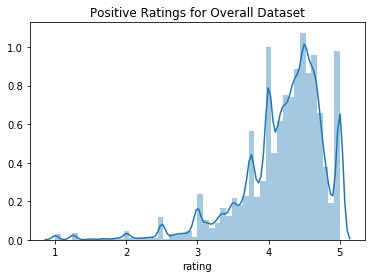

There are 104,253 non-zero ratings in the dataset


In [18]:
sns.distplot(recipe_df.rating[recipe_df.rating>0].dropna())
plt.title('Positive Ratings for Overall Dataset')
plt.show()

print("There are {:,d} non-zero ratings in the dataset".format(recipe_df.rating[recipe_df.rating>0].notnull().sum()))

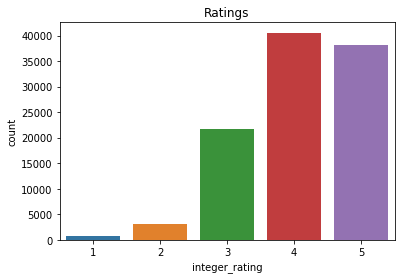

In [19]:
# create 5 categories for ratings

recipe_df['integer_rating'] = pd.Series(0, index=recipe_df.index)
recipe_df.loc[(df_all.rating > 0)&(recipe_df.rating < 2),'integer_rating'] = 1
recipe_df.loc[(df_all.rating >= 2)&(recipe_df.rating < 3),'integer_rating'] = 2
recipe_df.loc[(df_all.rating >= 3)&(recipe_df.rating < 4),'integer_rating'] = 3
recipe_df.loc[(df_all.rating >= 4)&(recipe_df.rating < 4.5),'integer_rating'] = 4
recipe_df.loc[(df_all.rating >= 4.5),'integer_rating'] = 5

sns.countplot(recipe_df.integer_rating[recipe_df.integer_rating>0])
plt.title('Ratings')
plt.show()

There are not enough lower ratings for 5 classes, therefore we will reclassify the ratings into 3 classes. 1-3 will be 'would not recommend', 4 will be 'would recommend', and 5 will be 'highly recommend'.

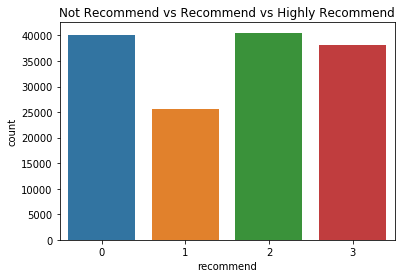

In [53]:
# 3 Classes for ratings
# 1 = 'would not recommend'
# 2 = 'would recommend'
# 3 = 'highly recommend'

recipe_df['recommend'] = pd.Series(0, index=recipe_df.index)
recipe_df.loc[(recipe_df.integer_rating>0)&(recipe_df.integer_rating<=3),'recommend'] = 1
recipe_df.loc[(recipe_df.integer_rating==4),'recommend'] = 2
recipe_df.loc[(recipe_df.integer_rating==5),'recommend'] = 3

# A rating of 0 is a missing
sns.countplot(recipe_df.recommend)
plt.title("Missing vs Not Recommend vs Recommend vs Highly Recommend")
plt.show()

# Train on 80% of rated recipes - use tfidf vectors for features
rated_index = recipe_df[recipe_df.recommend>0].index
y = recipe_df.recommend.iloc[rated_index]
tfidf_features = X[X.indices[rated_index]]

# Split training and test
xtrain, xtest, ytrain, ytest = train_test_split(tfidf_features, y, test_size=0.2, random_state=34)

In [54]:
def rate(model, label):
    clf = model
    clf.fit(xtrain, ytrain)
    
    # Predict on test
    clf_pred = clf.predict(xtest)
    
    # Score test
    print(label)
    print("Accuracy:",clf.score(xtest,ytest))
    print(confusion_matrix(ytest,clf_pred))
    print(classification_report(ytest, clf_pred))
    print('_'*75)
    return

In [55]:
# Naive Bayes
rate(MultinomialNB(), 'Multinomial')
rate(ComplementNB(), 'Complement')

Multinomial
Accuracy: 0.39168385209342477
[[  52 3871 1189]
 [  55 6069 1911]
 [  39 5619 2046]]
              precision    recall  f1-score   support

           1       0.36      0.01      0.02      5112
           2       0.39      0.76      0.51      8035
           3       0.40      0.27      0.32      7704

   micro avg       0.39      0.39      0.39     20851
   macro avg       0.38      0.34      0.28     20851
weighted avg       0.38      0.39      0.32     20851

___________________________________________________________________________
Complement
Accuracy: 0.3771042156251499
[[ 682 2621 1809]
 [ 917 4194 2924]
 [ 783 3934 2987]]
              precision    recall  f1-score   support

           1       0.29      0.13      0.18      5112
           2       0.39      0.52      0.45      8035
           3       0.39      0.39      0.39      7704

   micro avg       0.38      0.38      0.38     20851
   macro avg       0.35      0.35      0.34     20851
weighted avg       0.36  

In [56]:
# KNN
rate(KNeighborsClassifier(),'KNN')

KNN
Accuracy: 0.3366265406934919
[[1693 1925 1494]
 [2582 3046 2407]
 [2463 2961 2280]]
              precision    recall  f1-score   support

           1       0.25      0.33      0.29      5112
           2       0.38      0.38      0.38      8035
           3       0.37      0.30      0.33      7704

   micro avg       0.34      0.34      0.34     20851
   macro avg       0.33      0.34      0.33     20851
weighted avg       0.35      0.34      0.34     20851

___________________________________________________________________________


In [57]:
# Random Forest
rfc = RandomForestClassifier(n_estimators=10,
                             max_depth=5,
                             random_state=34)
rate(rfc, "RFC")

RFC
Accuracy: 0.38741547168001533
[[   0 5020   92]
 [   0 7900  135]
 [   0 7526  178]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      5112
           2       0.39      0.98      0.55      8035
           3       0.44      0.02      0.04      7704

   micro avg       0.39      0.39      0.39     20851
   macro avg       0.28      0.34      0.20     20851
weighted avg       0.31      0.39      0.23     20851

___________________________________________________________________________


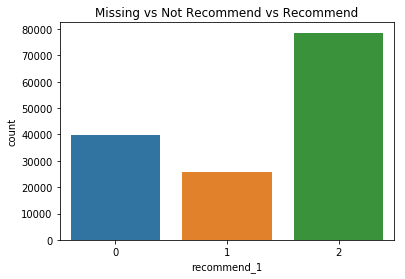

Multinomial
Accuracy: 0.7546400652246895
[[    0  5112]
 [    4 15735]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      5112
           2       0.75      1.00      0.86     15739

   micro avg       0.75      0.75      0.75     20851
   macro avg       0.38      0.50      0.43     20851
weighted avg       0.57      0.75      0.65     20851

___________________________________________________________________________
Complement
Accuracy: 0.7443767685003118
[[  133  4979]
 [  351 15388]]
              precision    recall  f1-score   support

           1       0.27      0.03      0.05      5112
           2       0.76      0.98      0.85     15739

   micro avg       0.74      0.74      0.74     20851
   macro avg       0.52      0.50      0.45     20851
weighted avg       0.64      0.74      0.66     20851

___________________________________________________________________________


In [58]:
# 2 Classes for ratings
# 1 = 'would not recommend'
# 2 = 'would recommend'

recipe_df['recommend_1'] = pd.Series(0, index=recipe_df.index)
recipe_df.loc[(recipe_df.integer_rating>0)&(recipe_df.integer_rating<=3),'recommend_1'] = 1
recipe_df.loc[(recipe_df.integer_rating>=4),'recommend_1'] = 2

# A rating of 0 is a missing
sns.countplot(recipe_df.recommend_1)
plt.title("Missing vs Not Recommend vs Recommend")
plt.show()

# Train on 80% of rated recipes - use tfidf vectors for features
rated_index = recipe_df[recipe_df.recommend_1>0].index
y = recipe_df.recommend_1.iloc[rated_index]
tfidf_features = X[X.indices[rated_index]]

# Split training and test
xtrain, xtest, ytrain, ytest = train_test_split(tfidf_features, y, test_size=0.2, random_state=34)

# Naive Bayes
rate(MultinomialNB(), 'Multinomial')
rate(ComplementNB(), 'Complement')

In [ ]:
def top_n_idx_sparse(csr_matrix, n=10):
    '''Return index of top n values in each row of a sparse matrix'''
    
    top_n_idx = []
    
    # Get the indices and tfidf values for each recipe from the csr matrix  
    for left, right in zip(csr_matrix.indptr[:-1], csr_matrix.indptr[1:]):
        
        # Makes sure vector has enough non-zero elemets
        n_row_pick = min(n,right-left)
        
        # Append top n indices
        top_n_idx.append(csr_matrix.indices[left+np.argpartition(csr_matrix.data[left:right],-n_row_pick)[-n_row_pick:]])
    return top_n_idx

def get_keywords(index_list):
    '''Returns keys that match values in dictionary'''
    matching_keys = []
    dict_items = vocab.items()
    
    for item in dict_items:
        if item[1] in index_list:
            matching_keys.append(item[0])
            
    # Zip tfidf values to words
    return matching_keys

######### Allows for faster results because can now handle flattened list #############
def get_keywords1(dictionary, index_list, n=10):
    '''Returns keys that match values in dictionary'''
    matching_keys = []
    dict_items = dictionary.items()
    
    # loop through flat list of indices - faster that get_keywords because allows a flatlist to be searched 
    # instead of requiring a loop through each list of indices
    counter=0
    for x in index_list:
        for item in dict_items:
            if x == item[1]:
                matching_keys.append(item[0])
                counter+=1
                if counter%100==0:
                    print('running...{}'.format(counter))
                
                
    # Split the results into the n number of keywords
    i=0
    row=0
    new_list=[]
    while i<len(matching_keys):
        new_list.append(matching_keys[i:i+n])
        i+=n
        row+=1
        if row%5000 ==0:
            print("Running row {}".format(row))
    return new_list


# Get indices for the keywords
#t0=time.time()
#keyword_indices = top_n_idx_sparse(X)

# Get list of keywords lists to add to recipe_df
#list_of_keywords = [l for subl in keyword_indices for l in subl]
    
# Add to recipe_df
#keyword_list = get_keywords1(vocab,list_of_keywords)

#print("Time to get keywords: {:0.5f}s".format(time.time()-t0))
#print(recipe_df.head())

In [ ]:
def brain_food(input_list):
    """Function that takes up to 10 ingredients and 
    returns recipes with keywords that are the most similar to the input"""
    t0=time.time()
    # Get idf score for each word entered.  If word is not in corpus throw error.
    idf_dict = dict(zip(tfidf_vectorizer.get_feature_names(),tfidf_vectorizer.idf_))
    
    input_vect = []
    for word in input_list:
        if word in idf_dict:
            input_vect.append(idf_dict[word])
            
        else:
            input_vect.append(0)
            print('{} not in corpus - no idf available'.format(word))
            
    # Make sure array has same number of elements as keywords
    num_keywords = len(recipe_df.keyword_vectors[0])
    ingredients = np.pad(input_vect, (0,(num_keywords-len(input_vect))), 'constant', constant_values=(0))
    
    # Get cosine similarity between input and rows
    sims = {}
    chunk = 1000
    chunk_df = recipe_df.sample(chunk)
    vectors = chunk_df.keyword_vectors.values
    index = chunk_df.index
    t = list(zip(index,vectors))
    counter = 0
    for label,array in t:
        if counter % 1000 == 0:
            print("running row", counter)
        padded_array = np.pad(array, (0,(num_keywords-len(array))), 'constant', constant_values=(0))
        sims[label] = cosine_similarity(ingredients.reshape(1, -1),padded_array.reshape(1, -1))[0]
        sims_df = pd.Series(sims).sort_values(ascending=False)
        counter+=1
        
    # Match index to recipe_df
    top=10
    top_ten = sims_df.index[:top]
    top_recipes = []
    for recipe in top_ten:
        top_recipes.append(recipe_df.loc[recipe,['title','description', 'ingredients', 'instructions', 
                                                 'url', 'integer_rating', 'tfidf_keywords_scores']])
    print("Done! Time for top {} recipes searched from {}:\n{:0.5f}s".format(top, chunk,(time.time()-t0)))
    return sims_df[:10], top_recipes
  
#brain_food(['bacon', 'eggs', 'cheese', 'bread', 'sausage', 'coffee'])

In [ ]:
# Gensim Keywords

#print(keywords(recipe_df.cleaned_text_2[0]).split('\n'))
#t0=time.time()
#recipe_df['gensim_keyword'] = recipe_df.cleaned_text_2.apply(keywords).apply(lambda x: x.split('\n'))
#print("Time for gensim keywords: {0:.5f}s".format(time.time()-t0))

#gensim_set = set([word for sublist in recipe_df.gensim_keyword.tolist() for word in sublist])
#print(gensim_set[:100])

#t0=time.time()
#count_vec = CountVectorizer(strip_accents='unicode',
                                   #min_df=2,                # keep words that occur more than 2 times
                                   #stop_words='english',    # English stop words
                                   ##vocabulary=gensim_set,   # Build on gensim keywords from each recipe
                                   #binary=True)             # use binary flag to indicate whether or not word is present
                            
#gensim_matrix = count_vec.fit_transform(doc_lemma)
#print("Time to build tfidf keyword matrix: {:0.5f}s".format(time.time()-t0))
#print(gensim_matrix.shape)

#gensim_vocab = count_vec.vocabulary_

# Build matrix on tfidf keywords

In [37]:
# Get set of unique words from tfidf keywords
keyword_set = set([word for sublist in recipe_df.tfidf_keywords.tolist() for word in sublist])

# Revectorize the recipes using only the tfidf keywords vocabulary
# use a binary flag to increase the diversity of recipes returned
count_vec = CountVectorizer(strip_accents='unicode',
                            min_df=2,                # keep words that occur more than 2 times
                            stop_words='english',    # English stop words
                            vocabulary=keyword_set,  # Build on keywords from each recipe
                            binary=True)             # use binary flag to indicate whether or not word is present
                            
tfidf_keyword_matrix = count_vec.fit_transform(doc_lemma)

# Tfidf vocabulary
tfidf_keyword_vocab = count_vec.vocabulary_

####################################################################################

def brain_food_3(input_list):
    ''' Adds additional similar words
        Keyword matrix built on tfidf keywords'''
    
    # Parse into spacy and get lemmas
    tokens = nlp(input_list)
    lemmas = get_lemmas(tokens)
    
    # Input vector needs to match matrix shape
    input_vec = np.zeros(tfidf_keyword_matrix.shape[1])
    
    # Add most similar word to input vector to increase diversity
    lemmas = lemmas.split()
    similar_to_input = []
    for word in lemmas:
        similar_to_input.append(w2v.wv.most_similar(word,topn=1)[0][0])
        
    diverse_lemmas = lemmas+similar_to_input
    
    print("Your keyword ingredients are:\n",diverse_lemmas)
    
    # One hot encode input vector
    for word in diverse_lemmas:
        input_vec[tfidf_keyword_vocab[word]] += 1
 
    # Multiply tfidf matrix by input vector and sum
    tfidf_keyword_sparse = scipy.sparse.csc_matrix(tfidf_keyword_matrix)
    similarity = tfidf_keyword_sparse * input_vec
    
    
    # add to recipe_df
    recipe_df_alias = recipe_df.copy()
    recipe_df_alias['similarity'] = similarity
    recipe_df_alias = recipe_df_alias.sort_values(by='similarity', ascending=False)
    
    return recipe_df_alias[['title', 'cleaned_text_2', 'tfidf_keywords','url']].head(10)

# Run Function
#brain_food_3('potatoes cheese bacon eggs')